In [56]:
import pandas as pd
import seaborn as sns
import igraph
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm

# import local functions
import os
import sys
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)
from functions.author_fns import Author, compare_nets

%matplotlib inline

## Load data

In [57]:
method = 'florida'
node_2_gender = np.load('%s/data/%s_node_2_gender.npy'%('..',method),allow_pickle='TRUE').item()
g = igraph.load('../data/florida_coa_graph',format='pickle')

## Parameter distributions and constants

#### Thresholds and constants

In [58]:
nAuth = 1000
learn_thr = .1
c = 3
diam = 3
net_size = 500
bib_length = 100
woman_perc = sum([x['gender'] == 'woman' for x in node_2_gender.values()])/len(node_2_gender)
colors = ['#d97d5b', '#4a3b90', '#5295d0', '#fabc50']

#### Netbias
Max shows that coauthorship is a modest predictor of over/under citation. 10% overinfluence for MM,, close to even for WW

In [59]:
# parameters (mean, stdev) for each distribution
net_w = (.5,.1)
net_m = (.4,.1)

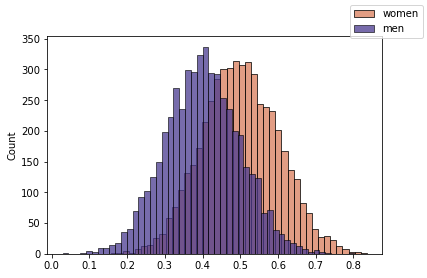

In [60]:
f,ax = plt.subplots(1,1,figsize=(6,4))
sns.histplot(np.random.normal(loc=net_w[0],scale=net_w[1],size=5000), color=colors[0])
sns.histplot(np.random.normal(loc=net_m[0],scale=net_m[1],size=5000), color=colors[1])
f.legend(labels=['women','men'])

#### Walk bias
Taken from jordans paper, MM cite WW teams about 25% less than you would expect. WW overcite 10%

In [77]:
walk_w = (.55,.05)
walk_m = (.30,.05)

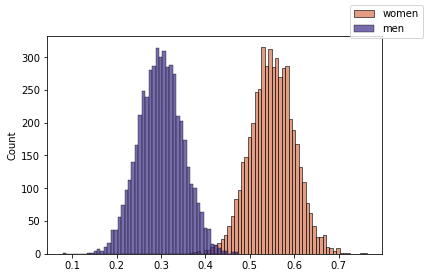

In [78]:
f,ax = plt.subplots(1,1,figsize=(6,4))
sns.histplot(np.random.normal(loc=walk_w[0],scale=walk_w[1],size=5000), color=colors[0])
sns.histplot(np.random.normal(loc=walk_m[0],scale=walk_m[1],size=5000), color=colors[1])
f.legend(labels=['women','men'])

#### Meet bias
People in the majority are less interdisciplinary

In [86]:
meet_w = (0.02,0.005)
meet_m = (0.03,0.005)

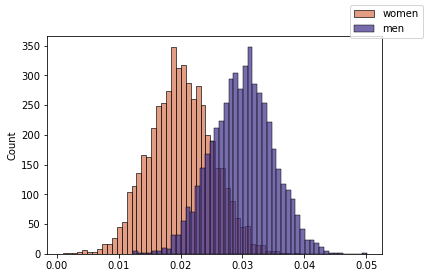

In [87]:
f,ax = plt.subplots(1,1,figsize=(6,4))
sns.histplot(np.random.normal(loc=meet_w[0],scale=meet_w[1],size=5000), color=colors[0])
sns.histplot(np.random.normal(loc=meet_m[0],scale=meet_m[1],size=5000), color=colors[1])
f.legend(labels=['women','men'])

People might tend to meet with people who share similar values (i.e. biases)

In [84]:
meetb_w = (0.2,0.05)
meetb_m = (0.3,0.05)

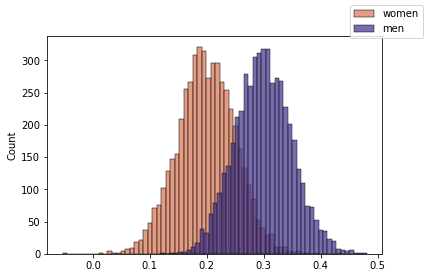

In [85]:
f,ax = plt.subplots(1,1,figsize=(6,4))
sns.histplot(np.random.normal(loc=meet_w[0],scale=meetb_w[1],size=5000), color=colors[0])
sns.histplot(np.random.normal(loc=meet_m[0],scale=meetb_m[1],size=5000), color=colors[1])
f.legend(labels=['women','men'])

#### Learn bias
Mean taken from Chris's paper. Women more remember things from diverse groups better (citation)?

In [65]:
learn_w = (-.5,.75)
learn_m = (-1,.75)

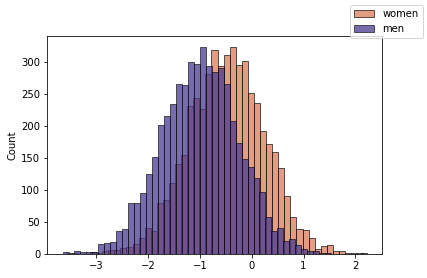

In [66]:
f,ax = plt.subplots(1,1,figsize=(6,4))
sns.histplot(np.log(np.random.lognormal(mean=learn_w[0],sigma=learn_w[1],size=5000)), color=colors[0])
sns.histplot(np.log(np.random.lognormal(mean=learn_m[0],sigma=learn_m[1],size=5000)), color=colors[1])
f.legend(labels=['women','men'])

## Simulations


#### Social

In [67]:
# generate authors
authors = []
for i in range(nAuth):
    if np.random.rand(1)[0] >= woman_perc:
        gen = 'M'
    else:
        gen = 'W'
    # draw biases
    if gen == 'M':
        net = np.random.normal(loc=net_m[0],scale=net_m[1],size=1)[0]
        walk = np.random.normal(loc=walk_m[0],scale=walk_m[1],size=1)[0]
        meet = np.random.normal(loc=meet_m[0],scale=meet_m[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_m[0],sigma=learn_m[1],size=1)[0]
    else:
        net = np.random.normal(loc=net_w[0],scale=net_w[1],size=1)[0]
        walk = np.random.normal(loc=walk_w[0],scale=walk_w[1],size=1)[0]
        meet = np.random.normal(loc=meet_w[0],scale=meet_w[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_m[0],sigma=learn_m[1],size=1)[0]
    # make object
    a = Author(net,walk,meet,learn,gen)
    a.init_network(g,node_2_gender,net_size,diam,c)
    authors.append(a)


In [68]:
# simulate meetings
nMeetings = 10000
meets = {}; # keep track of when meetings were successful
citation_perc = [];
citation_perc_w = [];
citation_perc_m = [];
w_index = [a.gender == 'W' for a in authors]
# run simulation
for i in tqdm(range(nMeetings)):
    # draw random authors
    auths = np.random.choice(range(nAuth),2)
    
    # check if at least one will meet
    [m12,m21] = compare_nets(authors[auths[0]], authors[auths[1]])
    if any([m12,m21]):
        # if yes, update the network
        if m12:
            bib = authors[auths[1]].get_cites(bib_length)
            authors[auths[0]].update_network(bib, authors[auths[1]].network, learn_thr)
        if m21:
            bib = authors[auths[0]].get_cites(bib_length)
            authors[auths[1]].update_network(bib, authors[auths[0]].network, learn_thr)
    # log information
    # update meets
    meets[i] = {'gender': authors[auths[0]].gender + authors[auths[1]].gender, 'meet':[m12,m21]}
    # update cites
    bibs = [a.get_cites(bib_length) for a in authors]
    bibs_w = [b for i,b in enumerate(bibs) if w_index[i]]
    bibs_m = [b for i,b in enumerate(bibs) if not(w_index[i])]
    citation_perc.append(np.mean([cite['gender'] == 'woman' for b in bibs for cite in b.values()]))
    citation_perc_w.append(np.mean([cite['gender'] == 'woman' for b in bibs_w for cite in b.values()]))
    citation_perc_m.append(np.mean([cite['gender'] == 'woman' for b in bibs_m for cite in b.values()]))
    

100%|██████████| 10000/10000 [16:06:44<00:00,  5.80s/it] 


/Users/stiso/anaconda2/envs/mod_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

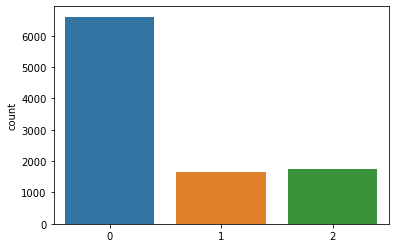

In [69]:
# plots
sns.countplot([sum(x['meet']) for x in meets.values()])

Text(0.5, 1.0, 'Percentage citation of women')

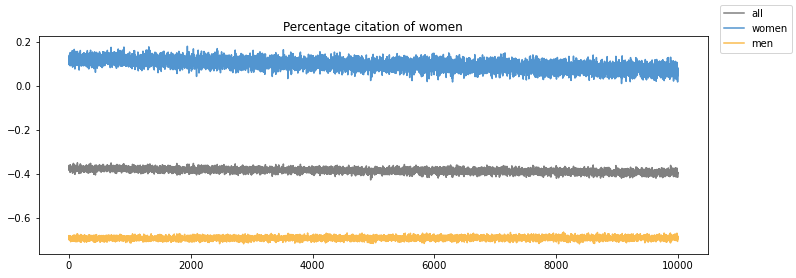

In [70]:
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=(np.array(citation_perc)/woman_perc) - 1, color='grey',ax=ax)
sns.lineplot(data=(np.array(citation_perc_w)/woman_perc) - 1, color=colors[2],ax=ax)
sns.lineplot(data=(np.array(citation_perc_m)/woman_perc) - 1, color=colors[3],ax=ax)
f.legend(labels=['all','women','men'])
ax.set_title('Percentage citation of women')

Text(0.5, 1.0, 'Womens Citation Practices')

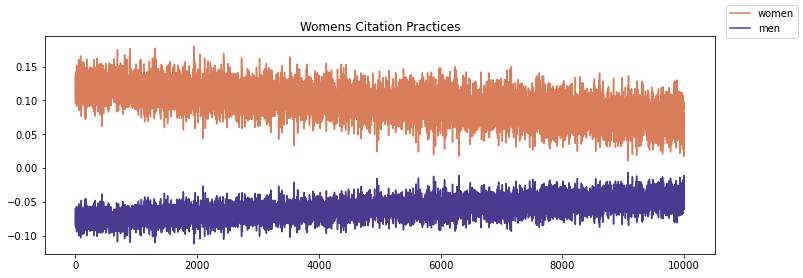

In [71]:
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=((np.array(citation_perc_w) - woman_perc)/woman_perc), color=colors[0],ax=ax)
sns.lineplot(data=((1 - np.array(citation_perc_w)) - (1 - woman_perc))/(1 - woman_perc), color=colors[1],ax=ax)
f.legend(labels=['women','men'])
ax.set_title('Womens Citation Practices')

Text(0.5, 1.0, 'Mens Citation Practices')

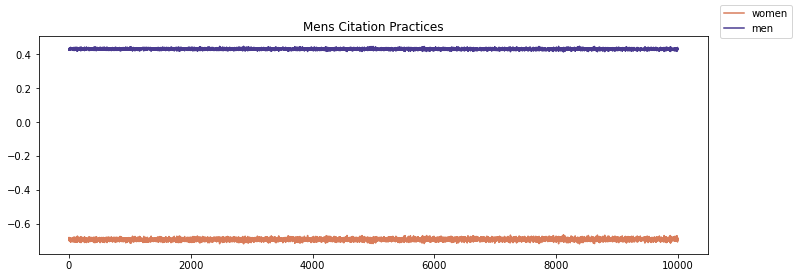

In [81]:
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=((np.array(citation_perc_m) - woman_perc)/woman_perc), color=colors[0],ax=ax)
sns.lineplot(data=((1 - np.array(citation_perc_m)) - (1 - woman_perc))/(1 - woman_perc), color=colors[1],ax=ax)
f.legend(labels=['women','men'])
ax.set_title('Mens Citation Practices')

#### Bias

In [ ]:
# generate authors
authors = []
for i in range(nAuth):
    if np.random.rand(1)[0] >= woman_perc:
        gen = 'M'
    else:
        gen = 'W'
    # draw biases
    if gen == 'M':
        net = np.random.normal(loc=net_m[0],scale=net_m[1],size=1)[0]
        walk = np.random.normal(loc=walk_m[0],scale=walk_m[1],size=1)[0]
        meet = np.random.normal(loc=meetb_m[0],scale=meet_m[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_m[0],sigma=learn_m[1],size=1)[0]
    else:
        net = np.random.normal(loc=net_w[0],scale=net_w[1],size=1)[0]
        walk = np.random.normal(loc=walk_w[0],scale=walk_w[1],size=1)[0]
        meet = np.random.normal(loc=meetb_w[0],scale=meet_w[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_m[0],sigma=learn_m[1],size=1)[0]
    # make object
    a = Author(net,walk,meet,learn,gen)
    a.init_network(g,node_2_gender,net_size,diam,c)
    authors.append(a)


In [ ]:
# simulate meetings
nMeetings = 10000
meets = {}; # keep track of when meetings were successful
citation_perc = [];
citation_perc_w = [];
citation_perc_m = [];
w_index = [a.gender == 'W' for a in authors]
# run simulation
for i in tqdm(range(nMeetings)):
    # draw random authors
    auths = np.random.choice(range(nAuth),2)
    
    # check if at least one will meet
    [m12,m21] = compare_nets(authors[auths[0]], authors[auths[1]],method='bi')
    if any([m12,m21]):
        # if yes, update the network
        if m12:
            bib = authors[auths[1]].get_cites(bib_length)
            authors[auths[0]].update_network(bib, authors[auths[1]].network, learn_thr)
        if m21:
            bib = authors[auths[0]].get_cites(bib_length)
            authors[auths[1]].update_network(bib, authors[auths[0]].network, learn_thr)
    # log information
    # update meets
    meets[i] = {'gender': authors[auths[0]].gender + authors[auths[1]].gender, 'meet':[m12,m21]}
    # update cites
    bibs = [a.get_cites(bib_length) for a in authors]
    bibs_w = [b for i,b in enumerate(bibs) if w_index[i]]
    bibs_m = [b for i,b in enumerate(bibs) if not(w_index[i])]
    citation_perc.append(np.mean([cite['gender'] == 'woman' for b in bibs for cite in b.values()]))
    citation_perc_w.append(np.mean([cite['gender'] == 'woman' for b in bibs_w for cite in b.values()]))
    citation_perc_m.append(np.mean([cite['gender'] == 'woman' for b in bibs_m for cite in b.values()]))

In [ ]:
# plots
sns.countplot([sum(x['meet']) for x in meets.values()])

In [ ]:
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=(np.array(citation_perc)/woman_perc) - 1, color='grey',ax=ax)
sns.lineplot(data=(np.array(citation_perc_w)/woman_perc) - 1, color=colors[2],ax=ax)
sns.lineplot(data=(np.array(citation_perc_m)/woman_perc) - 1, color=colors[3],ax=ax)
f.legend(labels=['all','women','men'])
ax.set_title('Percentage citation of women')

In [ ]:
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=((np.array(citation_perc_w) - woman_perc)/woman_perc), color=colors[0],ax=ax)
sns.lineplot(data=((1 - np.array(citation_perc_w)) - (1 - woman_perc))/(1 - woman_perc), color=colors[1],ax=ax)
f.legend(labels=['women','men'])
ax.set_title('Womens Citation Practices')

In [ ]:
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=((np.array(citation_perc_m) - woman_perc)/woman_perc), color=colors[0],ax=ax)
sns.lineplot(data=((1 - np.array(citation_perc_m)) - (1 - woman_perc))/(1 - woman_perc), color=colors[1],ax=ax)
f.legend(labels=['women','men'])
ax.set_title('Mens Citation Practices')